In [1]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.optimization.ising import docplex, max_cut, tsp
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

# DOcplex
from docplex.mp.model import Model

In [2]:
def draw_tsp_solution(G, order, colors, pos):
    G2 = G.copy()
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

distance
 [[  0.  66. 104.]
 [ 66.   0.  66.]
 [104.  66.   0.]]


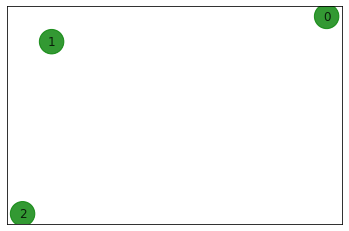

In [3]:
# Generating a graph of 3 nodes
n = 3
#num_qubits = n ** 2
ins = tsp.random_tsp(n)
#ins = tsp.parse_tsplib_format()
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
colors = ['g' for node in G.nodes()]
pos = {k: v for k, v in enumerate(ins.coord)}
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
print('distance\n', ins.w)

In [4]:
# Create an instance of a model and variables
mdl = Model(name='tsp')
x = {(i,p): mdl.binary_var(name='x{0}{1}'.format(i,p)) for i in range(n) for p in range(n)}

# Object function
tsp_func = mdl.sum(ins.w[i,j] * x[(i,p)] * x[(j,(p+1)%n)] for i in range(n) for j in range(n) for p in range(n))
mdl.minimize(tsp_func)

# Constrains
for i in range(n):
    mdl.add_constraint(mdl.sum(x[(i,p)] for p in range(n)) == 1)
for p in range(n):
    mdl.add_constraint(mdl.sum(x[(i,p)] for i in range(n)) == 1)
    
print(mdl.export_to_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: tsp

Minimize
 obj: [ 132 x00*x11 + 132 x00*x12 + 208 x00*x21 + 208 x00*x22 + 132 x01*x10
      + 132 x01*x12 + 208 x01*x20 + 208 x01*x22 + 132 x02*x10 + 132 x02*x11
      + 208 x02*x20 + 208 x02*x21 + 132 x10*x21 + 132 x10*x22 + 132 x11*x20
      + 132 x11*x22 + 132 x12*x20 + 132 x12*x21 ]/2
Subject To
 c1: x00 + x01 + x02 = 1
 c2: x10 + x11 + x12 = 1
 c3: x20 + x21 + x22 = 1
 c4: x00 + x10 + x20 = 1
 c5: x01 + x11 + x21 = 1
 c6: x02 + x12 + x22 = 1

Bounds
 0 <= x00 <= 1
 0 <= x01 <= 1
 0 <= x02 <= 1
 0 <= x10 <= 1
 0 <= x11 <= 1
 0 <= x12 <= 1
 0 <= x20 <= 1
 0 <= x21 <= 1
 0 <= x22 <= 1

Binaries
 x00 x01 x02 x10 x11 x12 x20 x21 x22
End



In [5]:
qubitOp, offset = docplex.get_operator(mdl)
print(qubitOp)
print("offset: ", offset)

Representation: paulis, qubits: 9, size: 45
offset:  8856.0


In [6]:
# checking the full Hamiltonian
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = ExactEigensolver(qubitOp, k=1)
result = ee.run()

"""
algorithm_cfg = {
    'name': 'ExactEigensolver',
}

params = {
    'problem': {'name': 'ising'},
    'algorithm': algorithm_cfg
}
result = run_algorithm(params,algo_input)
"""
print('energy:', result['energy'])
print('tsp objective:', result['energy'] + offset)
x = tsp.sample_most_likely(result['eigvecs'][0])
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))

energy: -8620.0
tsp objective: 236.0
feasible: True
solution: [2, 1, 0]
solution objective: 236.0


C:\Users\TobiasBergmann\Anaconda3\lib\site-packages\qiskit\optimization\ising\tsp.py:279: DeprecationWarning: sample_most_likely function has been moved to qiskit.optimization.ising.common, the method here will be removed after Aqua 0.7+
  DeprecationWarning)


C:\Users\TobiasBergmann\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


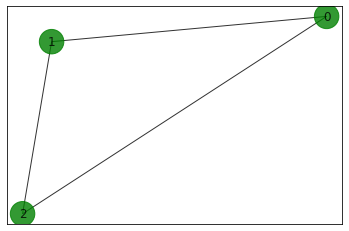

In [7]:
draw_tsp_solution(G, z, colors, pos)

In [8]:
print(result)

{'eigvals': array([-8620.+0.j]), 'eigvecs': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 

In [9]:
# Statevector simulation
seed = 10598
spsa = SPSA(max_trials=300)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)
backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed,seed_transpiler=seed)
result = vqe.run(quantum_instance)
x = tsp.sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('solution objective:', result['energy'] + offset)
print('solution:', x)

energy: -8567.862723266475
time: 14.064800024032593
solution objective: 288.13727673352514
solution: [0. 0. 1. 0. 1. 0. 1. 0. 0.]


C:\Users\TobiasBergmann\Anaconda3\lib\site-packages\qiskit\optimization\ising\tsp.py:279: DeprecationWarning: sample_most_likely function has been moved to qiskit.optimization.ising.common, the method here will be removed after Aqua 0.7+
  DeprecationWarning)


In [10]:
print(result)

{'num_optimizer_evals': None, 'min_val': -8567.862723266475, 'opt_params': array([-8.77089337e-01, -1.60635331e-01,  5.07526775e+00, -3.12903360e+00,
        1.42131372e+00,  9.17816950e-01,  8.02848938e-01, -5.73498833e+00,
       -3.58645027e+00,  3.51007269e-01, -2.03873658e+00, -1.26268272e+00,
       -9.39222626e-01, -3.15230893e+00,  9.42049209e-03,  2.71851660e+00,
        1.61545789e+00, -2.96827973e+00,  1.58177731e+00,  2.01055104e+00,
        3.16613480e+00, -1.55574330e+00, -1.36680305e+00, -1.38859292e+00,
        3.83479188e+00,  1.43088165e+00,  1.04801292e+00, -2.22225446e+00,
        5.67940775e-01, -5.64838230e+00,  1.54320382e+00,  3.93881344e+00,
       -3.21969254e-01,  4.53214006e+00, -2.25010706e-01,  2.79552655e+00,
        3.16296404e+00, -5.07377818e-03, -3.61537252e+00,  3.03107498e+00,
        4.46538294e+00,  5.79149748e+00, -4.21890111e+00, -3.87467991e+00,
        3.01612849e+00,  3.53755540e+00, -9.42365631e-02, -2.02423021e+00,
       -2.71828497e-01,  

In [11]:
# run quantum algorithm with shots

seed = 10598

spsa = SPSA(max_trials=300)
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')
vqe = VQE(qubitOp, ry, spsa)

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=10, seed_simulator=seed, seed_transpiler=seed)

In [12]:
result = vqe.run(quantum_instance)

print('energy:', result['energy'])
print('time:', result['eval_time'])

energy: -5925.799999999997
time: 110.65838575363159


In [13]:
#print('tsp objective:', result['energy'] + offset)
x = tsp.sample_most_likely(result['eigvecs'][0])
print('feasible:', tsp.tsp_feasible(x))

feasible: False


C:\Users\TobiasBergmann\Anaconda3\lib\site-packages\qiskit\optimization\ising\tsp.py:279: DeprecationWarning: sample_most_likely function has been moved to qiskit.optimization.ising.common, the method here will be removed after Aqua 0.7+
  DeprecationWarning)


In [14]:
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))

solution: [1, 0]
solution objective: 132.0


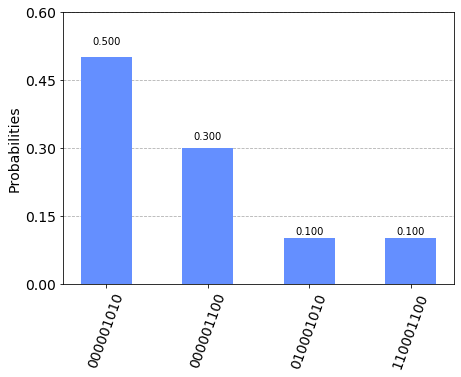

In [15]:
plot_histogram(result['eigvecs'][0])

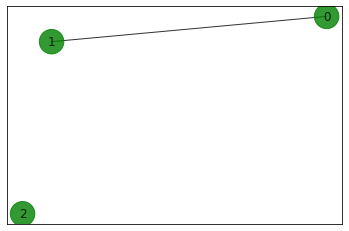

In [16]:
draw_tsp_solution(G, z, colors, pos)

In [17]:
print(result)

{'num_optimizer_evals': None, 'min_val': -5925.799999999997, 'opt_params': array([-4.84947685, -0.34518777, -5.48466624,  3.53128226, -4.74155058,
        0.14360436,  0.06178923,  0.67818973,  1.65880677, -6.53271385,
        2.85250547, -0.26909708, -5.17399831, -1.60755335, -2.64886664,
        3.6633399 ,  6.32675198,  0.40454812,  0.57307539, -3.48557018,
        0.86281681, -8.3400468 ,  0.82027891,  1.95410568, -1.30362354,
       -1.17338146,  6.02258794, -4.43714638, -3.99140998,  2.40739444,
        0.13103206,  6.27598999, -2.92915503, -2.01317542,  0.09437486,
       -3.67697184, -3.3915157 ,  0.6882736 ,  5.24964793, -2.34648823,
        3.78561624,  0.15826726, -2.82846526,  1.72486613,  5.42152502,
        1.49944424,  1.5011926 , -1.11614704,  5.05742077, -0.05774235,
       -3.65603236, -1.41341249,  5.16116381,  2.3025171 ]), 'eval_time': 110.65838575363159, 'eval_count': 651, 'energy': -5925.799999999997, 'eigvals': array([-5925.8]), 'min_vector': {'000001010': 5, '0